In [ ]:
!pip install tpot
!pip install scikit-mdr skrebate


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from tpot import TPOTClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from google.colab import drive

import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import SGDClassifier
import sklearn.linear_model
import sklearn.pipeline
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set environment as googledrive to folder "resource"
data_path =  "/resource/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/resource/"

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(data_path + '/output v11 updated v10.csv')
print(df.head(5))

   index                                               text  value
0      1  Şok market ürünleri oldukça taze ve kaliteli. ...      1
1      2  @TurkNetDestek Tek akıllı o götünü orada büyüt...      0
2      3  @GuluserCiddi Sizlere kaliteli ve uygun fiyatl...      0
3      4  Kulübün renkleri kırmızı ve siyah olarak olara...      0
4      5  gerçekten kargo hızlı ve ürün kalitesi iyi teş...      1


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105494 entries, 0 to 105493
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   105494 non-null  int64 
 1   text    105494 non-null  object
 2   value   105494 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB
None


Modelleme öncesinde hem veriyi küçültmek hemde sadece anlam içeren ifadeleri set içerisinde tutabilmek için durma sözcüklerini corpus içerisinden kaldırdık. Eğitime clean_data yı dahil edeceğimizden text kolonunda bu değişikliği yapmayarak ham veri ile farkını gözle gözlemledik.

In [ ]:
# Remove stop words
stopwordSet = set(stopwords.words('turkish'))
def stop_word(text):
    text = word_tokenize(text, language='turkish')
    text = [word for word in text if not word in stopwordSet]
    text = " ".join(text)
    return text

df['clean_data'] = df.text.apply(stop_word)

In [ ]:
# Check and remove duplicates
print("Duplicate entries before cleaning:", df[df.duplicated(subset='text')].count())
df.drop_duplicates(subset='clean_data', inplace=True)
print("Duplicate entries after cleaning:", df[df.duplicated(subset='clean_data')].count())
print(df.head())

Duplicate entries before cleaning: index         51
text          51
value         51
clean_data    51
dtype: int64
Duplicate entries after cleaning: index         0
text          0
value         0
clean_data    0
dtype: int64
   index                                               text  value  \
0      1  Şok market ürünleri oldukça taze ve kaliteli. ...      1   
1      2  @TurkNetDestek Tek akıllı o götünü orada büyüt...      0   
2      3  @GuluserCiddi Sizlere kaliteli ve uygun fiyatl...      0   
3      4  Kulübün renkleri kırmızı ve siyah olarak olara...      0   
4      5  gerçekten kargo hızlı ve ürün kalitesi iyi teş...      1   

                                          clean_data  
0  Şok market ürünleri oldukça taze kaliteli . Fi...  
1  @ TurkNetDestek Tek akıllı götünü orada büyüte...  
2  @ GuluserCiddi Sizlere kaliteli uygun fiyatlı ...  
3  Kulübün renkleri kırmızı siyah olarak olarak b...  
4  gerçekten kargo hızlı ürün kalitesi iyi teşekk...  


In [ ]:
# Word Cloud Generation
def generate_wordcloud(words, sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("{} Kategorisinde Geçen Favori Kelimeler".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')


Kelime Balonu Oluşturuluyor...


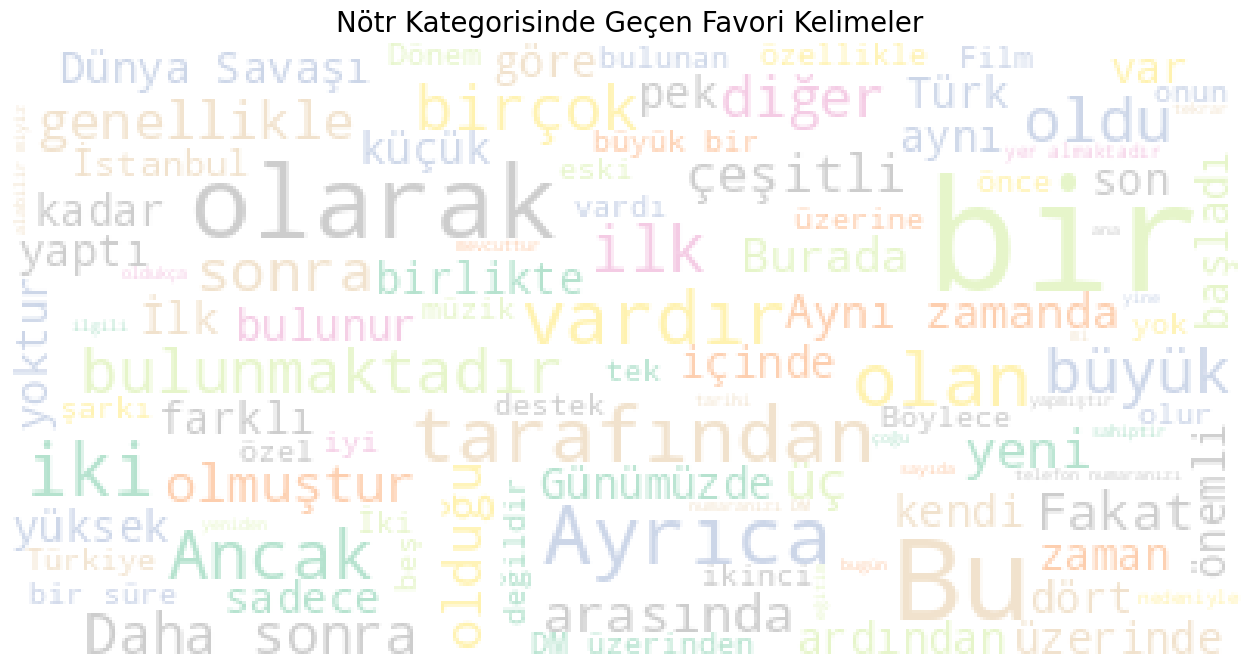

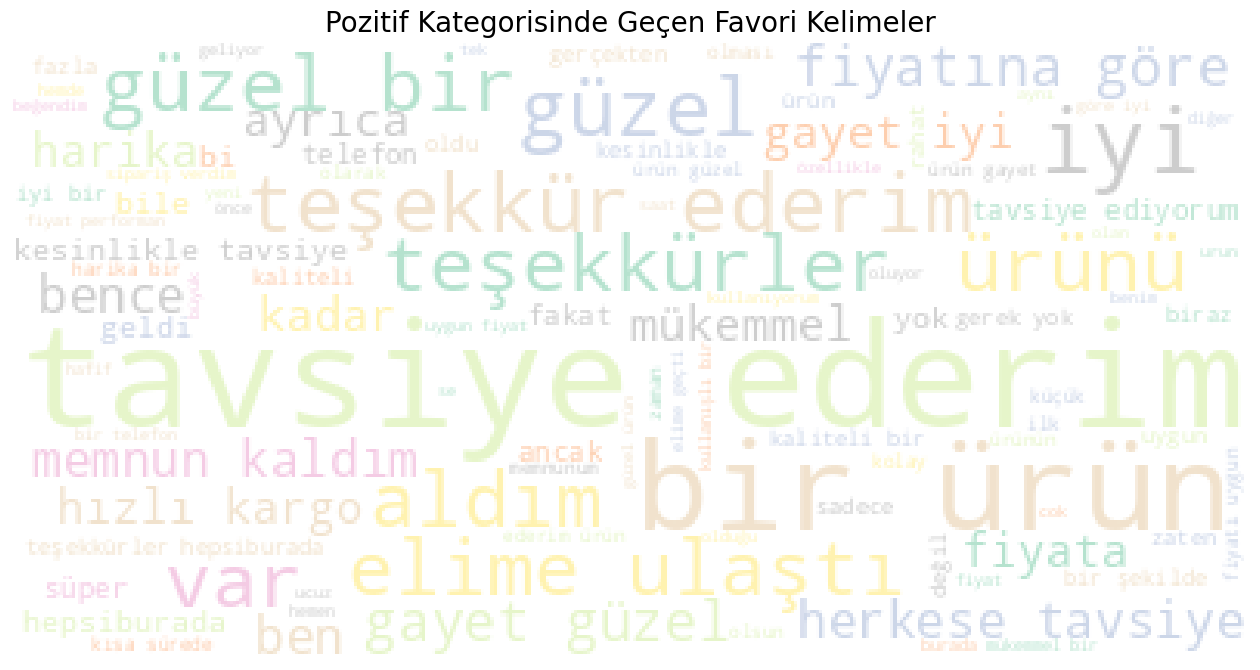

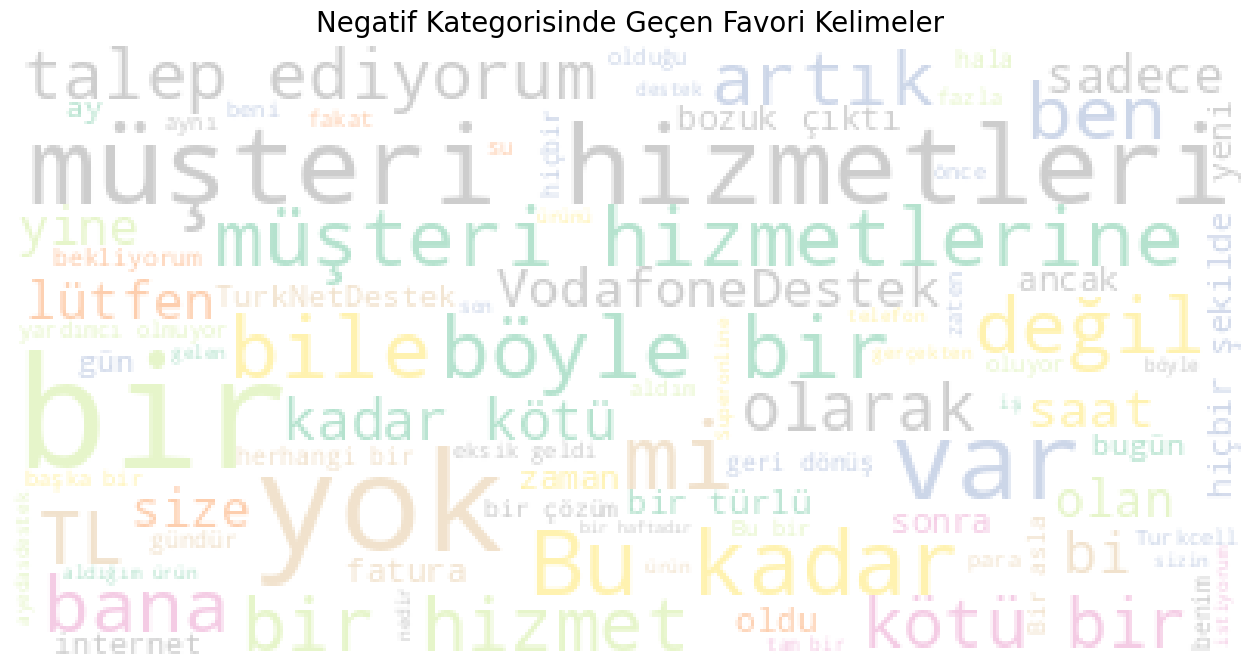

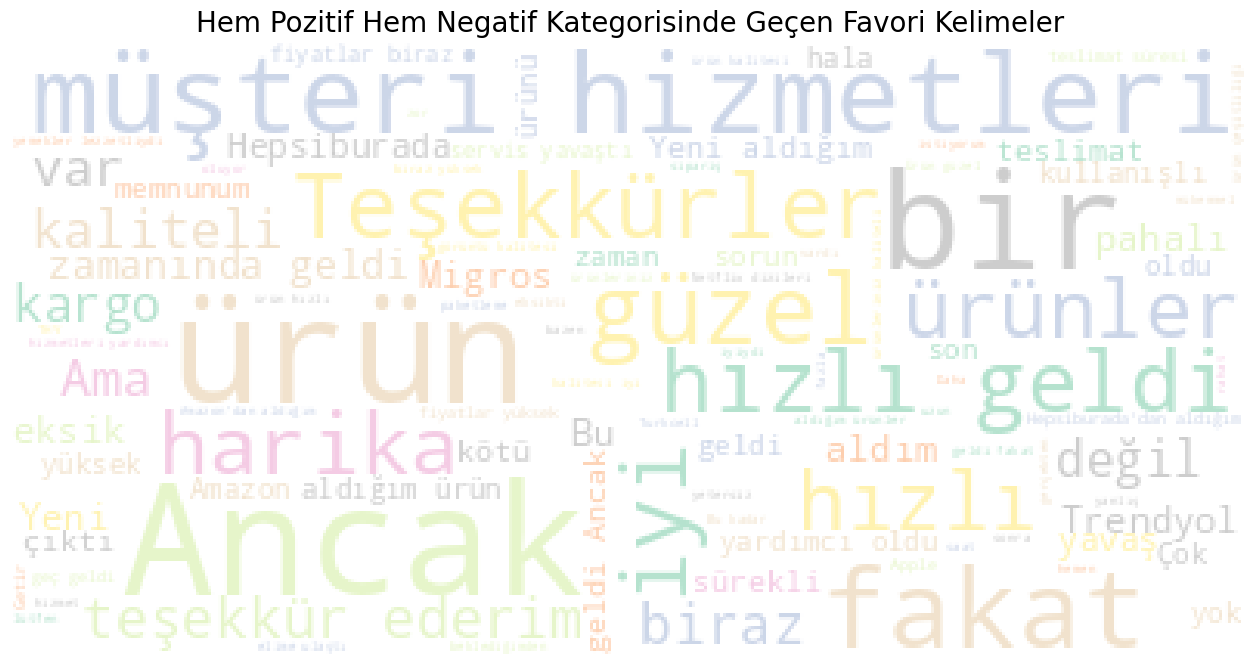

In [ ]:
print("Kelime Balonu Oluşturuluyor...")
neutral = " ".join(df[df.value==0]['clean_data'].values)
positive = " ".join(df[df.value==1]['clean_data'].values)
negative = " ".join(df[df.value==2]['clean_data'].values)
both = " ".join(df[df.value==3]['clean_data'].values)

generate_wordcloud(neutral, "Nötr")
generate_wordcloud(positive, "Pozitif")
generate_wordcloud(negative, "Negatif")
generate_wordcloud(both, "Hem Pozitif Hem Negatif")


Sık kullanılan kelimelerin sınıflara göre kırılımına baktığımızda modelin recall değerini düşürebilecek metrikleri önceden tahmin edebiliyoruz.

In [ ]:
# Frequency Analysis
def freq(df_series):
    word_freq = df_series.str.split(expand=True).stack().value_counts()
    word_freq = word_freq.reset_index(name='freq').rename(columns={'index': 'clean_data'})
    top_15_frequent_words = word_freq[:15]
    print(top_15_frequent_words)

Aşağıda yaptığımız sık kullanılan kelimelerin sınıflara göre kırılımı analizi ile Irkçılık ve Kızdırmanın ortak bir çok kelime içerdiğini fark ettik.

In [ ]:
label_list = [df[df.value==0]['clean_data'],
              df[df.value==1]['clean_data'],
              df[df.value==2]['clean_data'],
              df[df.value==3]['clean_data']]

for i in label_list:
    freq(i)
    print('\n--------------------------\n')


    clean_data   freq
0            .  31825
1            @   6605
2          bir   5291
3           Bu   2752
4       olarak   2646
5            ’   1728
6            #   1590
7        sonra   1247
8           ''   1149
9           ``   1143
10  tarafından   1069
11           ?    951
12         iki    927
13      vardır    796
14         yer    707

--------------------------

     clean_data   freq
0             .  38246
1           bir  12302
2             ,   9476
3          ürün   9433
4        ederim   5635
5         güzel   5631
6       tavsiye   5542
7           iyi   5359
8         gayet   3576
9   teşekkürler   3336
10        hızlı   3272
11        aldım   2890
12     kaliteli   2786
13          ...   2563
14        uygun   2545

--------------------------

   clean_data   freq
0           .  16976
1           @  14204
2         bir   6910
3           ?   3984
4           !   2433
5           #   2109
6         yok   2036
7          Bu   1882
8       kadar   1689
9     müşter

Aşağıda veri setinin yüzdelik dağılımını inceledik. Bu sonuç bize model eğitimi bittikten sonra bakmamız gereken tek metriğin accuracy olmadığını göstermiştir. Ayrıca Irkçılık ve Kızdırma verilerinin toplam sayısına göre muhtemelen Irkçılık verileri ile Kızdırma verileri arasında False Negative - False Positive yüksek olacak ve bu da modelin F1-score unu düşürecektir.

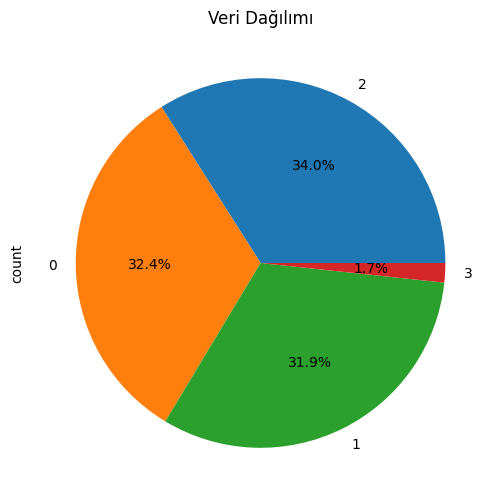

In [ ]:
# Data Distribution
df['value'].value_counts().plot.pie(figsize=(6,6), title="Veri Dağılımı", autopct='%1.1f%%')
plt.gca().set_aspect('equal')
plt.show()
